<a href="https://colab.research.google.com/github/itshimanshu2602/Krotov_Test_Optimization-with-numpy-Arrays/blob/main/krotov_test2_Optimization_with_numpy_Arrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 27.9 MB/s eta 0:00:00


In [2]:
pip install krotov

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.2/192.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.5 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=0598075f13e99b60db2e1ec6de890e91ac22cb987053f157e8d6301693756f8e
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme
  Attempting uninstall: scipy
  

In [3]:
pip install cython numpy

In [4]:
pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:00:00


In [5]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
# note that qutip is NOT imported
%watermark -v --iversions

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

matplotlib: 3.8.0
krotov    : 1.3.0
numpy     : 1.26.4
scipy     : 1.12.0



In [6]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * np.array([[1, 0], [0, -1]], dtype=np.complex128)
    H1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )

    return [H0, [H1, guess_control]]


In [7]:
H = hamiltonian()

In [8]:
krotov.Objective.type_checking = False

In [9]:
ket0 = np.array([[1], [0]], dtype=np.complex128)
ket1 = np.array([[0], [1]], dtype=np.complex128)

In [10]:
objectives = [
    krotov.Objective(initial_state=ket0, target=ket1, H=H)
]

objectives

[Objective[a₀[2,1] to a₁[2,1] via [a₂[2,2], [a₃[2,2], u₁(t)]]]]

In [11]:
def expm(H, state, dt, c_ops=None, backwards=False, initialize=False):
    eqm_factor = -1j  # factor in front of H on rhs of the equation of motion
    if backwards:
        eqm_factor = eqm_factor.conjugate()
    A = eqm_factor * H[0]
    for part in H[1:]:
        A += (eqm_factor * part[1]) * part[0]
    return scipy.linalg.expm(A * dt) @ state

In [12]:
proj0 = np.array([[1, 0],[0, 0]], dtype=np.complex128)
proj1 = np.array([[0, 0],[0, 1]], dtype=np.complex128)

In [13]:
def expect(proj, state):
    return complex(state.conj().T @ (proj @ state)).real

In [14]:
tlist = np.linspace(0, 5, 500)

In [15]:
guess_dynamics = objectives[0].propagate(
    tlist, propagator=expm, e_ops=[proj0, proj1], expect=expect
)

<ipython-input-13-add2b7478d11>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return complex(state.conj().T @ (proj @ state)).real
<ipython-input-13-add2b7478d11>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return complex(state.conj().T @ (proj @ state)).real


In [16]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

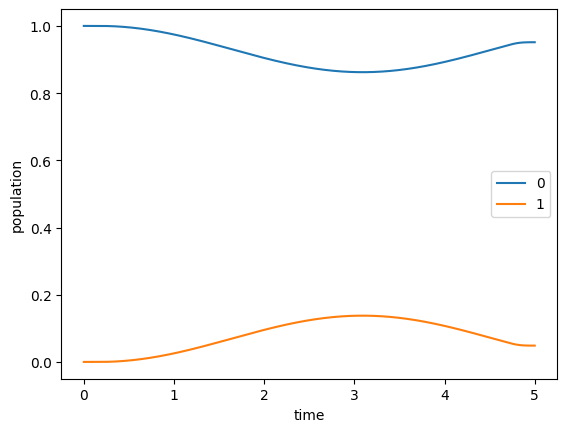

In [17]:
plot_population(guess_dynamics)

In [18]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

In [19]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

In [20]:
def mu(objectives, i_objective, pulses, pulses_mapping, i_pulse, time_index):
    def _mu(state):
        return H[1][0] @ state
    return _mu

In [21]:
def overlap(psi1, psi2):
    return complex(psi1.conj().T @ psi2)

In [22]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.check_monotonic_error,
    iter_stop=10,
    norm=np.linalg.norm,
    mu=mu,
    overlap=overlap,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.51e-01    0.00e+00   9.51e-01        n/a        n/a     0
1     9.24e-01    1.20e-02   9.36e-01  -2.71e-02  -1.50e-02     0


<ipython-input-21-4d475c76a89c>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return complex(psi1.conj().T @ psi2)


2     8.83e-01    1.83e-02   9.02e-01  -4.11e-02  -2.28e-02     0
3     8.23e-01    2.71e-02   8.50e-01  -6.06e-02  -3.35e-02     0
4     7.37e-01    3.84e-02   7.76e-01  -8.52e-02  -4.68e-02     0
5     6.26e-01    5.07e-02   6.77e-01  -1.11e-01  -6.05e-02     0
6     4.96e-01    6.04e-02   5.56e-01  -1.31e-01  -7.02e-02     0
7     3.62e-01    6.30e-02   4.25e-01  -1.34e-01  -7.09e-02     0
8     2.44e-01    5.65e-02   3.00e-01  -1.18e-01  -6.15e-02     0
9     1.53e-01    4.39e-02   1.97e-01  -9.03e-02  -4.64e-02     0
10    9.20e-02    3.02e-02   1.22e-01  -6.14e-02  -3.12e-02     0


In [23]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-11-10 07:44:12
- Number of objectives: 1
- Number of iterations: 10
- Reason for termination: Reached 10 iterations
- Ended at 2024-11-10 07:44:13 (0:00:01)